# Demonstration of the MESD toolbox to compute the MESD metric as AAD performance metric 

This notebook demonstrates how the MESD metric can be computed based on evaluated performance points.  

The MESD is computed in four steps:
* **1.** Construction of the performance curve by interpolating through the evaluated (on real EEG and audio data) (decision window length,accuracy)-points.  
* **2.** Optimization of the Markov chain in the number of states N for each sampled point tau on the performance curve.
* **3.** Computation of the exected switch duration (ESD) per sampled tau and corresponding optimal number of states N.
* **4.** The MESD is equal to the minimal ESD over all sampled decision window lengths.

If this method has been useful for you, please cite the following:

[1] S. Geirnaert, T. Francart, and A. Bertrand, “An Interpretable Performance Metric for Auditory Attention Decoding Algorithms in a Context of Neuro-Steered Gain Control,” August 2019, Internal Report  
[2] S. Geirnaert, T. Francart, and A. Bertrand, “A New Metric to Evaluate Auditory Attention Detection Performance Based on a Markov Chain,” Accepted for publication in Proc. European Signal Processing Conference (EUSIPCO), A Coruña, Spain, Sept. 2019  
[3] S. Geirnaert, T. Francart, and A. Bertrand, “MESD toolbox,” August 2019, Available online, URL: https://github.com/exporl/mesd-toolbox

Author: Debora Fieberg, KU Leuven  
Department of Neurosciences, Research Group Experimental Oto-rhino-laryngology &
Department of Electrical Engineering (ESAT), STADIUS Center for Dynamical Systems, Signal Processing and Data Analytics  

Correspondence: debora.fieberg@kuleuven.be

In [4]:
import matplotlib.pyplot as plt # plotting
from scipy.io import loadmat    # to load the mat file of a toy example
import pandas as pd             # just to display the results

# add path of MESD toolbox and import desired functions 
import sys          
sys.path.append('../mesd-toolbox-python')
from mesd_toolbox import * # compute_ESD,compute_MESD, optimize_Markov_chain, compute_targetState_and_EMTT, interpolate_performance_curve  


# Load some dummy evaluated (decision time,accuracy)-points of three decoders:
data = loadmat('demoData.mat') 

alg = 0 # for now, we just look at the resutls of one algorithm
p = data['p'][0][alg][0]; print('p    = ', p)
tau = data['tau'][0][alg][0]; print('tau  = ', tau)

p    =  [0.53 0.61 0.69 0.76 0.84 0.9 ]
tau  =  [ 1  5 10 20 30 60]


## Step 1: Interpolate the performance curves and display them
The performance curve is constructed by linear interpolating through the evaluated points.

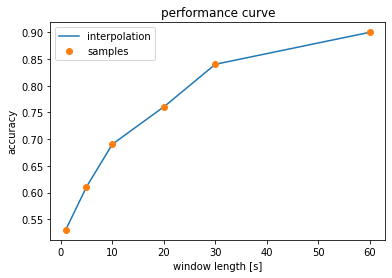

In [5]:
tau_Ip, p_Ip = interpolate_performance_curve(tau,p)

# plot the performance curve
plt.plot(tau_Ip, p_Ip, '-', label='interpolation')
plt.plot(tau, p, 'o', label='samples')
plt.xlabel('window length [s]'); plt.ylabel('accuracy'); plt.title('performance curve')
plt.legend()
plt.show()

## Step 2: Optimize the Markov chain per sampled point on the performance curve of each decoder

Per $\tau$ on the performance curve, a Markov chain is optimized via the lower bound of the $P_0$-confidence interval. The arguments consist of the sampled accuracies and hyperparameter $N_\text{min}$ (default: 5), $P_0$ (default: 0.8) and $c$ (default: 0.65).

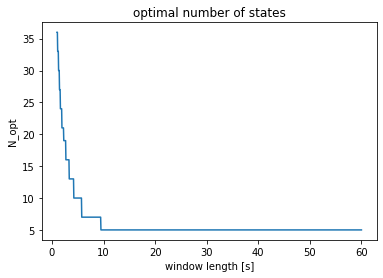

In [6]:
N_min = 5; P0 = 0.8; c = 0.65 # the hyperparameters
N_opt = optimize_Markov_chain(tau_Ip, p_Ip, N_min, P0, c)

# plot the optimal number of states in function of tau
# plot the optimal number of states
plt.plot(tau_Ip, N_opt, '-')
plt.xlabel('window length [s]'); plt.ylabel('N_opt'); plt.title('optimal number of states')
plt.show()

## Step 3: Compute the expected switch duration per sampled point

Per point on the performance curve, the expected switch duration is computed, using the optimized Markov chain.
We calculate both the target state and the respective expected switch duration.

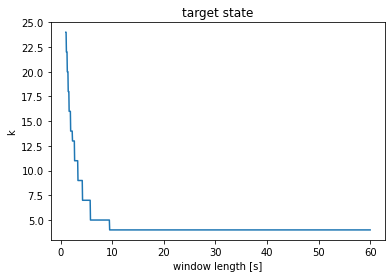

Text(0.5, 1.0, 'expected switch duration')

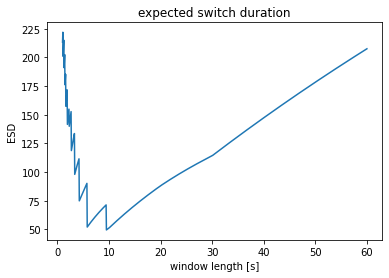

In [7]:
ESD, kc = compute_targetState_and_EMTT(tau_Ip, p_Ip, N_opt, c)

# plot the target state 
plt.plot(tau_Ip, kc, '-')
plt.xlabel('window length [s]'); plt.ylabel('k'); plt.title('target state')
plt.show()

# plot the expected switch duration
plt.plot(tau_Ip, ESD, '-')
plt.xlabel('window length [s]'); plt.ylabel('ESD'); plt.title('expected switch duration')

## Step 4. Compute the MESD

The MESD is equal to the minimal ESD over the performance curve.

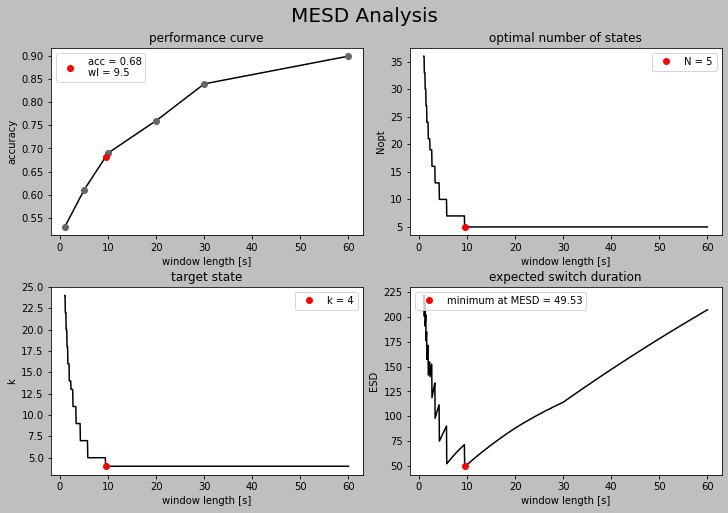

In [8]:
mesd = np.min(ESD); ind = np.argmin(ESD)

N_mesd = N_opt[ind]
tau_mesd = tau_Ip[ind]
p_mesd = p_Ip[ind]
k_mesd = kc[ind]

# Show the optimal working point in an overview figure:

plt.style.use('grayscale')
fig, axs = plt.subplots(2,2,figsize=(10,7),constrained_layout=True)

fig.suptitle("MESD Analysis",fontsize=20)
opt_color = "red"

# plot the performance curve:
axs[0,0].plot(tau_Ip, p_Ip, '-', tau, p, 'o')
axs[0,0].plot(tau_mesd, p_mesd, 'o', color = opt_color, label = f"acc = {np.round(p_mesd,decimals=2)}\nwl = {np.round(tau_mesd,decimals=2)}")
axs[0,0].set_xlabel('window length [s]'); axs[0,0].set_ylabel('accuracy'); axs[0,0].set_title('performance curve')
axs[0,0].legend(loc='upper left')

# plot the optimal number of states
axs[0,1].plot(tau_Ip, N_opt, '-')
axs[0,1].plot(tau_mesd, N_mesd, 'o', color = opt_color, label = f"N = {np.round(N_mesd,decimals=0)}")
axs[0,1].set_xlabel('window length [s]'); axs[0,1].set_ylabel('Nopt'); axs[0,1].set_title('optimal number of states')
axs[0,1].legend(loc='upper right')

# plot the target state 
axs[1,0].plot(tau_Ip, kc, '-')
axs[1,0].plot(tau_mesd, k_mesd, 'o', color = opt_color, label = f"k = {np.round(k_mesd,decimals=0)}")
axs[1,0].set_xlabel('window length [s]'); axs[1,0].set_ylabel('k'); axs[1,0].set_title('target state')
axs[1,0].legend(loc='upper right')

# plot the expected switch duration
axs[1,1].plot(tau_Ip, ESD, '-')
axs[1,1].plot(tau_mesd, mesd, 'o', color = opt_color, label = f"minimum at MESD = {np.round(mesd,decimals=2)}")
axs[1,1].set_xlabel('window length [s]'); axs[1,1].set_ylabel('ESD'); axs[1,1].set_title('expected switch duration')
axs[1,1].legend(loc='upper left')

plt.show()


This can all be computed with the main-function 'compute_MESD':

In [9]:
mesd, N_mesd, tau_mesd, p_mesd = compute_MESD(tau,p)

print(f"The minimal expected switch duration is MESD = {mesd} \nat an otpimal working point of (tau, p) = ({tau_mesd}, {p_mesd}) \nwith N = {N_mesd} states in the Markov chain.")


The minimal expected switch duration is MESD = 49.52860783427647 
at an otpimal working point of (tau, p) = (9.504504504504505, 0.682072072072072) 
with N = 5 states in the Markov chain.


The hyperparameters can also be changed as follows. Note that the default values are $N_\text{min}=5$, $P_0=0.8$, $c=0.65$.

In [10]:
N_min = 10
mesd, N_mesd, tau_mesd, p_mesd = compute_MESD(tau,p,N_min)
print(f"For N_min={N_min}, the minimal expected switch duration is MESD = {mesd} \nat an otpimal working point of (tau, p) = ({tau_mesd}, {p_mesd}) \nwith N = {N_mesd} states in the Markov chain.")


# mesd, *_ = compute_MESD(tau, p) will only return the mesd value

For N_min=10, the minimal expected switch duration is MESD = 74.88432822327886 
at an otpimal working point of (tau, p) = (4.248248248248249, 0.594964964964965) 
with N = 10 states in the Markov chain.


In [11]:
P0 = 0.85; c=0.7
mesd, N_mesd, tau_mesd, p_mesd = compute_MESD(tau,p,N_min,P0,c)
print(f"For N_min = {N_min}, P0 = {P0}, and c = {c},\nthe minimal expected switch duration is MESD = {mesd} \nat an otpimal working point of (tau, p) = ({tau_mesd}, {p_mesd}) \nwith N = {N_mesd} states in the Markov chain.")

For N_min = 10, P0 = 0.85, and c = 0.7,
the minimal expected switch duration is MESD = 106.11963738695611 
at an otpimal working point of (tau, p) = (5.311311311311312, 0.614980980980981) 
with N = 11 states in the Markov chain.


# Compare now three algorithms with the MESD:

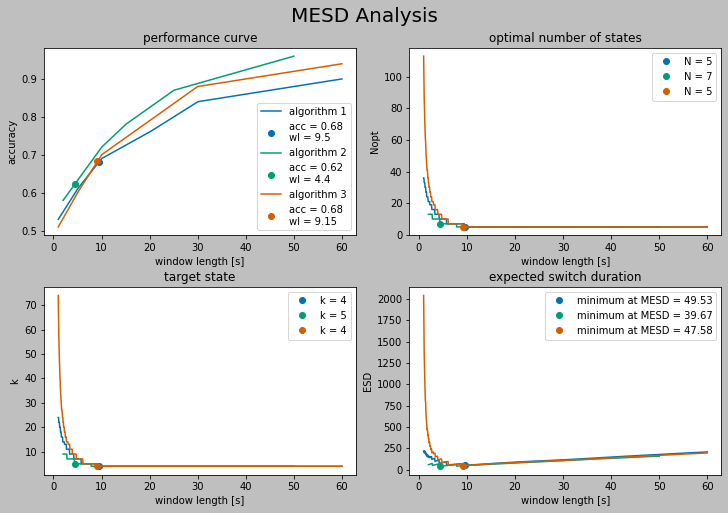



Results of the MESD analysis:

                  MESD  N_opt  windowlength_opt  accuracy_opt
Algorithm 1  49.528608      5          9.504505      0.682072
Algorithm 2  39.667786      7          4.402402      0.622042
Algorithm 3  47.576235      5          9.150150      0.683003


In [12]:
# Load some dummy evaluated (decision time,accuracy)-points of three decoders:
data = loadmat('demoData.mat') 

plt.style.use('seaborn-colorblind')
fig, axs = plt.subplots(2,2,figsize=(10,7),constrained_layout=True)
fig.suptitle("MESD Analysis",fontsize=20)

MESD_all = []; N_opt_all = []; tau_opt_all = []; p_opt_all = []

for alg in [0,1,2]:

    # load data per algorithm
    p = data['p'][0][alg][0]
    tau = data['tau'][0][alg][0]

    # calculate MESD and other entities
    N_min = 5; P0=0.8; c=0.65
    tau_Ip, p_Ip = interpolate_performance_curve(tau,p)
    N_opt = optimize_Markov_chain(tau_Ip, p_Ip, N_min, P0, c) 
    ESD, kc = compute_targetState_and_EMTT(tau_Ip, p_Ip, N_opt, c)
    mesd = np.min(ESD); ind = np.argmin(ESD)
    N_mesd = N_opt[ind]
    tau_mesd = tau_Ip[ind]
    p_mesd = p_Ip[ind]
    k_mesd = kc[ind]

    # save results
    MESD_all.append(mesd); N_opt_all.append(N_mesd); tau_opt_all.append(tau_mesd); p_opt_all.append(p_mesd); 

    # Show the optimal working point in an overview figure:

    # plot the performance curve:
    axs[0,0].plot(tau_Ip, p_Ip, '-', label = f"algorithm {alg+1}") #, tau, p, 'o')
    axs[0,0].plot(tau_mesd, p_mesd, 'o', color=axs[0,0].lines[-1].get_color(), label = f"acc = {np.round(p_mesd,decimals=2)}\nwl = {np.round(tau_mesd,decimals=2)}")
    axs[0,0].set_xlabel('window length [s]'); axs[0,0].set_ylabel('accuracy'); axs[0,0].set_title('performance curve')
    axs[0,0].legend(loc='lower right')

    # plot the optimal number of states
    axs[0,1].plot(tau_Ip, N_opt, '-')
    axs[0,1].plot(tau_mesd, N_mesd, 'o', color=axs[0,0].lines[-1].get_color(), label = f"N = {np.round(N_mesd,decimals=0)}")
    axs[0,1].set_xlabel('window length [s]'); axs[0,1].set_ylabel('Nopt'); axs[0,1].set_title('optimal number of states')
    axs[0,1].legend(loc='upper right')

    # plot the target state 
    axs[1,0].plot(tau_Ip, kc, '-')
    axs[1,0].plot(tau_mesd, k_mesd, 'o', color=axs[0,0].lines[-1].get_color(), label = f"k = {np.round(k_mesd,decimals=0)}")
    axs[1,0].set_xlabel('window length [s]'); axs[1,0].set_ylabel('k'); axs[1,0].set_title('target state')
    axs[1,0].legend(loc='upper right')

    # plot the expected switch duration
    axs[1,1].plot(tau_Ip, ESD, '-')
    axs[1,1].plot(tau_mesd, mesd, 'o', color=axs[0,0].lines[-1].get_color(), label = f"minimum at MESD = {np.round(mesd,decimals=2)}")
    axs[1,1].set_xlabel('window length [s]'); axs[1,1].set_ylabel('ESD'); axs[1,1].set_title('expected switch duration')
    axs[1,1].legend(loc='upper right')


plt.show()

# Display results
data = {'MESD': MESD_all, 'N_opt': N_opt_all, 'windowlength_opt': tau_opt_all, 'accuracy_opt': p_opt_all}    
df = pd.DataFrame(data); df = pd.DataFrame(data, index =['Algorithm 1', 'Algorithm 2', 'Algorithm 3'])  
print('\n\nResults of the MESD analysis:\n')  
print(df)